In [3]:
import numpy as np
import nrrd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import os

# Rename all files

In [18]:
src = ""


def rename_files(root, file, patient_id):
    if 'RTDOSE' in file:
        new_name = f"rtdose_{patient_id}.nrrd"
    elif 'GTV' in file:
        new_name = f"gtv_{patient_id}.nrrd"
    else :
        return
    old_file_path = os.path.join(root, file)
    new_file_path = os.path.join(root, new_name)
    os.rename(old_file_path, new_file_path)

def rename_mri_files(root, files, patient_id):
    mri_files = sorted([f for f in files if 'mr' in f.lower() and f.endswith('.nrrd')],
                       key=lambda x: x.split('_')[-1])
    
    if len(mri_files) == 2:
        pre_mri, post_mri = mri_files
        
        if "pre" in pre_mri or "post" in post_mri:
            return
        
        base_name_pre = "_".join(pre_mri.split('_')[:-1])
        base_name_post = "_".join(post_mri.split('_')[:-1])
        
        date_pre = pre_mri.split('_')[-1].split('.')[0]
        date_post = post_mri.split('_')[-1].split('.')[0]
        new_name_pre = f"{base_name_pre}_pre_{date_pre}.nrrd"
        new_name_post = f"{base_name_post}_post_{date_post}.nrrd"
        
        
        old_file_path_pre = os.path.join(root, pre_mri)
        new_file_path_pre = os.path.join(root, new_name_pre)
        os.rename(old_file_path_pre, new_file_path_pre)

        old_file_path_post = os.path.join(root, post_mri)
        new_file_path_post = os.path.join(root, new_name_post)
        os.rename(old_file_path_post, new_file_path_post)


for root, dirs, files in os.walk(src):
    patient_id = root.split(os.sep)[-1].split("_")[0].lower()
    rename_mri_files(root, files, patient_id)

    for file in files:
        if file.endswith(".nrrd"):
            rename_files(root, file, patient_id)



# Load data 

In [102]:
def load_data(folder):

    pre_treatment_mri = None
    post_treatment_mri = None
    rtdose = None
    gtv = None
    ct = None

    for file in os.listdir(folder):
        if file.endswith('.nrrd'):
            file_path = os.path.join(folder, file)
            data, header = nrrd.read(file_path)
            if 'pre' in file:
                pre_treatment_mri = data
            elif 'post' in file:
                post_treatment_mri = data
            elif 'rtdose' in file:
                rtdose = data
            elif 'gtv' in file:
                gtv = data
            elif 'ct' in file:
                ct = data
    
    return pre_treatment_mri, post_treatment_mri, rtdose, gtv, ct

In [103]:
folder = "./datas/dataset"
dataset = []

for root, dirs, files in os.walk(folder):
    for d in dirs:
        path = os.path.join(root, d)
        pre_treatment_mri, post_treatment_mri, rtdose, gtv, ct = load_data(path)
        dataset.append((pre_treatment_mri, post_treatment_mri, rtdose, gtv, ct))
        

In [104]:
def show_shapes(patient):
    print(f"Pre-treatment MRI shape: {patient[0].shape}")
    print(f"Post-treatment MRI shape: {patient[1].shape}")
    print(f"RTDOSE shape: {patient[2].shape}")
    print(f"GTV shape: {patient[3].shape}")
    print(f"CT shape: {patient[4].shape}")

show_shapes(dataset[0])

Pre-treatment MRI shape: (512, 512, 198)
Post-treatment MRI shape: (512, 512, 198)
RTDOSE shape: (356, 207, 186)
GTV shape: (512, 512, 198)
CT shape: (512, 512, 198)


In [105]:
def show_slice(data, slice_idx):
    fig, axes = plt.subplots(2, 2)

    axes[0, 0].imshow(pre_treatment_mri[:, :, 80], cmap='bone')
    axes[0, 0].set_title('Pre-treatment MRI')
    axes[0, 1].imshow(post_treatment_mri[:, :, 80], cmap='bone')
    axes[0, 1].set_title('Post-treatment MRI')
    axes[1, 0].imshow(rtdose[:, :, 80], cmap='bone')
    axes[1, 0].set_title('RTDOSE')
    axes[1, 1].imshow(gtv[:, :, 80], cmap='bone')
    axes[1, 1].set_title('GTV')

    for ax in axes.flatten():
        ax.axis('off')
    
    plt.tight_layout()
    ax_slider = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')

    slider = Slider(ax_slider, 'Slice', 0, 9, valinit=0, valstep=1)

    def update(val):

        slice_idx = int(slider.val)
        axes[0, 0].imshow(pre_treatment_mri[:, :, slice_idx], cmap='bone')
        axes[0, 1].imshow(post_treatment_mri[:, :, slice_idx], cmap='bone')
        axes[1, 0].imshow(rtdose[:, :, slice_idx], cmap='bone')
        axes[1, 1].imshow(gtv[:, :, slice_idx], cmap='bone')
        fig.canvas.draw_idle()

    slider.on_changed(update)

    plt.show()


# Extract in pre/post mri only frames with GTV

In [106]:
def extract_frames_with_gtv(pre, post, gtv, ct):
    pre_frames = []
    post_frames = []
    ct_frames = []
    
    if pre.shape !=  post.shape != gtv.shape != ct.shape:
        raise ValueError("Pre and post treatment MRI should have the same shape")
    
    
    for i in range(pre.shape[-1]):
        if np.any(gtv[:, :, i]):
            pre_frames.append(pre[:, :, i][None, ...])
            post_frames.append(post[:, :, i][None, ...])
            ct_frames.append(ct[:, :, i][None, ...])
            
    return pre_frames, post_frames, ct_frames


def global_extract(dataset):
    
    pre_frames_glob = []
    post_frames_glob = []
    rt_frames_glob = []
    
    for patient in dataset:
        pre_treatment_mri, post_treatment_mri, rtdose, gtv, ct = patient
        pre_frames, post_frames, rt_frames = extract_frames_with_gtv(pre_treatment_mri, post_treatment_mri, gtv, ct)
        pre_frames_glob.extend(pre_frames)
        post_frames_glob.extend(post_frames)
        rt_frames_glob.extend(rt_frames)
    
    return pre_frames_glob, post_frames_glob, rt_frames_glob
    


In [107]:
pre_frames_glob, post_frames_glob, rt_frames_glob = global_extract(dataset)

In [108]:
print(len(pre_frames_glob))
print(len(post_frames_glob))
print(len(rt_frames_glob))

280
280
280


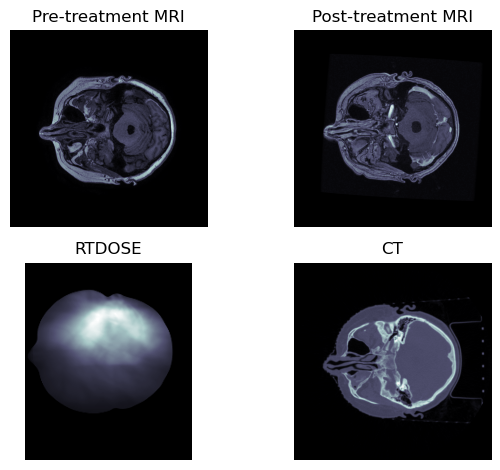

In [112]:
def imshow_patient(patient):
    pre_treatment_mri, post_treatment_mri, rtdose, gtv, ct = patient
    
    fig, axes = plt.subplots(2, 2)
    
    axes[0, 0].imshow(pre_treatment_mri[:, :, 80], cmap='bone')
    axes[0, 0].set_title('Pre-treatment MRI')
    
    axes[0, 1].imshow(post_treatment_mri[:, :, 80], cmap='bone')
    axes[0, 1].set_title('Post-treatment MRI')
    
    axes[1, 0].imshow(rtdose[:, :, 80], cmap='bone')
    axes[1, 0].set_title('RTDOSE')
    
    axes[1, 1].imshow(ct[:, :, 80], cmap='bone')
    axes[1, 1].set_title('CT')
    
    for ax in axes.flatten():
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
imshow_patient(dataset[3])

# Create torch dataset

In [122]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time

In [123]:
class MRIDataset(Dataset):
    def __init__(self, pre_frames, post_frames, rt_frames):
        self.pre_frames = pre_frames
        self.post_frames = post_frames
        self.rt_frames = rt_frames
        
    def __len__(self):
        return len(self.pre_frames)
    
    def __getitem__(self, idx):
        pre_frame = self.pre_frames[idx]
        post_frame = self.post_frames[idx]
        rt_frame = self.rt_frames[idx]
        
        pre_frame = torch.from_numpy(pre_frame).float()
        post_frame = torch.from_numpy(post_frame).float()
        rt_frame = torch.from_numpy(rt_frame).float()
        
        return pre_frame, post_frame, rt_frame

In [124]:
dataset = MRIDataset(pre_frames_glob, post_frames_glob, rt_frames_glob)

In [116]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
val_size = int(0.2 * train_size)
train_size = train_size - val_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)


In [117]:
for pre, post, ct in train_dataloader:
    print(pre.shape)
    print(post.shape)
    print(ct.shape)
    break

torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


# Create model

## UNet declaration

In [118]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # couche d'encodage
        self.enc_conv1 = self.double_conv(2, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)
        self.enc_conv5 = self.double_conv(512, 1024)

        # couche decocage
        self.dec_conv4 = self.double_conv(1024 + 512, 512)
        self.dec_conv3 = self.double_conv(512 + 256, 256)
        self.dec_conv2 = self.double_conv(256 + 128, 128)
        self.dec_conv1 = self.double_conv(128 + 64, 64)

        # sortie
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):

        # chemin descendant
        x1 = self.enc_conv1(x)
        x2 = self.pool(x1)
        x2 = self.enc_conv2(x2)
        x3 = self.pool(x2)
        x3 = self.enc_conv3(x3)
        x4 = self.pool(x3)
        x4 = self.enc_conv4(x4)
        x5 = self.pool(x4)
        x5 = self.enc_conv5(x5)

        # chemin ascendant
        x = self.up(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec_conv4(x)
        x = self.up(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv3(x)
        x = self.up(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        x = self.up(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv1(x)

        # sortie
        x = self.final_conv(x)
        return x


In [119]:
class DiffusionModel(nn.Module):
    def __init__(self, unet_model, num_timesteps):
        super(DiffusionModel, self).__init__()
        self.unet_model = unet_model.to(device)
        self.num_timesteps = num_timesteps
        self.beta_schedule = torch.linspace(0.0001, 0.02, num_timesteps).to(device) 

    def forward(self, x):
        
        t = torch.randint(0, self.num_timesteps, (x.size(0),), device=x.device)
        
        beta_t = self.beta_schedule[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)
        noise = torch.randn_like(x)
        noised_x = torch.sqrt(1 - beta_t) * x + torch.sqrt(beta_t) * noise

        # unet prediction du bruit
        predicted_noise = self.unet_model(noised_x)

        return predicted_noise


In [120]:
def train_diffusion_model(model, dataloader, optimizer, loss_function, num_epochs, beta_schedule, writer=None):
    model.to(device)
    num_batches = len(dataloader)
    saved_predicted = None
    saved_real = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_loss = 0.0
        start_time = time.time()
        for i, (pre_frame, post_frame, rt_frame) in enumerate(dataloader):
            print(f"Batch {i+1}/{len(dataloader)}", end='\r')
            pre_frame = pre_frame.to(device)
            post_frame = post_frame.to(device)
            rt_frame = rt_frame.to(device)

            t = torch.randint(0, len(beta_schedule), (pre_frame.size(0),), device=pre_frame.device)

            # calcul du bruit
            beta_t = beta_schedule[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)
            noise = torch.randn_like(pre_frame)
            noised_pre_frame = torch.sqrt(1 - beta_t) * pre_frame + torch.sqrt(beta_t) * noise

            # fusion de l'IRM prétraitement + la RTdose pour le passer dans le unet
            input_tensor = torch.cat([noised_pre_frame, rt_frame], dim=1)

            predicted_post_frame = model(input_tensor)

            # calcul de la loss
            loss = loss_function(predicted_post_frame, post_frame)
            epoch_loss += loss.item()
            
            if i == 0 and writer is not None:
                saved_predicted = predicted_post_frame[i].detach().cpu()
                saved_real = post_frame[i].detach().cpu()

            # mise a jour des poids
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        epoch_loss /= num_batches   
        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {end_time - start_time}s")
    
        if writer is not None:
            writer.add_scalar('Loss/train', epoch_loss, epoch)
            writer.add_image('Predicted Image', saved_predicted[0], epoch, dataformats='HW')
            writer.add_image('Real Image', saved_real[0], epoch, dataformats='HW')
            
            
        
        torch.save(model.state_dict(), 'checkpoint.pt')

In [121]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("le modèle tournera via votre GPU")
else:
    device = torch.device("cpu")
    print("le modèle tournera via votre CPU")
    

le modèle tournera via votre GPU


In [90]:
unet_model = UNet()
diffusion_model = DiffusionModel(unet_model, num_timesteps=10)

optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

beta_schedule = torch.linspace(0.0001, 0.02, 10).to(device)

writer = SummaryWriter()

train_diffusion_model(diffusion_model, train_dataloader, optimizer, loss_function, num_epochs=5, beta_schedule=beta_schedule,
                      writer=writer)

writer.close()

Epoch 1/5
Epoch [1/5], Loss: 1336126.4827, Time: 29.847410678863525s
Epoch 2/5
Epoch [2/5], Loss: 514807.3672, Time: 23.9511079788208s
Epoch 3/5
Epoch [3/5], Loss: 228112.5234, Time: 30.931827306747437s


KeyboardInterrupt: 

In [ ]:
torch.save(diffusion_model.state_dict(), 'diffusion_model.pt')

## Optimisation des hyperparamètres

In [2]:
import optuna
from optuna.trial import TrialState

In [4]:
def optimize_hyperparameters(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_layers = trial.suggest_int('num_layers', 2, 5)

    unet_model = UNet(num_layers=num_layers)
    diffusion_model = DiffusionModel(unet_model, num_timesteps=10)

    optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    for epoch in range(3):
        train_diffusion_model(diffusion_model, train_dataloader, optimizer, loss_function, num_epochs=1, beta_schedule=beta_schedule)

    loss = evaluate_model(diffusion_model, val_dataloader) 
    return loss



In [ ]:
def evaluate_model(model, dataloader):
    model.to(device)
    num_batches = len(dataloader)
    epoch_loss = 0.0
    start_time = time.time()
    for i, (pre_frame, post_frame, rt_frame) in enumerate(dataloader):
        print(f"Batch {i+1}/{len(dataloader)}", end='\r')
        pre_frame = pre_frame.to(device)
        post_frame = post_frame.to(device)
        rt_frame = rt_frame.to(device)

        t = torch.randint(0, len(beta_schedule), (pre_frame.size(0),), device=pre_frame.device)

        # calcul du bruit
        beta_t = beta_schedule[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)
        noise = torch.randn_like(pre_frame)
        noised_pre_frame = torch.sqrt(1 - beta_t) * pre_frame + torch.sqrt(beta_t) * noise

        # fusion de l'IRM prétraitement + la RTdose pour le passer dans le unet
        input_tensor = torch.cat([noised_pre_frame, rt_frame], dim=1)

        predicted_post_frame = model(input_tensor)

        # calcul de la loss
        loss = loss_function(predicted_post_frame, post_frame)
        epoch_loss += loss.item()

    epoch_loss /= num_batches   
    end_time = time.time()
    print(f"Loss: {epoch_loss:.4f}, Time: {end_time - start_time}s")
    return epoch_loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(optimize_hyperparameters, n_trials=10)

print(study.best_trial.params)